<span style="font-family:Helvetica Light">
    
# The Analysis

## The goal of this notebook:
The goal of this notebook is to analyze my Spotify listening data for 2021 and anwser few questions:
1. How much time did I spend on Spotify each month?
2. When in the week do I listen to music the most?
3. How do I use Spotify around the clock?
4. Do my habits change during the weekend?
5. What is the proportion of music vs podcasts?
6. What were my top podcasts of the year?
7. How did my musical moods change?
8. What were my the most popular genres?
9. Do I skip songs a lot?

## About plotly library
From the <a href="https://plotly.com/python/" target="_blank">Plotly documentation</a>:

<blockquote>The plotly Python library is an interactive, open-source plotting library that supports over 40 unique chart types covering a wide range of statistical, financial, geographic, scientific, and 3-dimensional use-cases.</blockquote>

In this notebook following chart types were used:
* <a href="https://plotly.com/python/bar-charts/" target="_blank">bar chart</a>
* <a href="https://plotly.com/python/histograms/" target="_blank">histogram</a>
* <a href="https://plotly.com/python/line-charts/" target="_blank">line chart</a>
* <a href="https://plotly.com/python/pie-charts/" target="_blank">pie chart</a>
* <a href="https://plotly.com/python/polar-chart/" target="_blank">polar chart</a>


#### References:
1. https://github.com/adautobraz/ergo/blob/master/spotify_unwrapped/scripts/My%20Year%20on%20Spotify%20-%20Analysis.py

</span>

<span style="font-family:Helvetica Light">
    
# 1. Set-up & Data Loading
    
Loading neccessary libraries.
    
Loading the streaming history file prepared in the previous step.
    
</span>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from datetime import time

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('spotify_my_streaming_history_2021_enriched_w_pod.csv',index_col=0)
df.head(2)

,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artistGenres,podcastName,podcastId,imageUrl
0,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,44827,6,2021-01-01,2020-12-28,2021-01-01,44.827,0.747117,...,0.013800,0.204,0.367,114.018,229474.0,4.0,"['polish alternative', 'polish pop']",NaN,NaN,NaN
1,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,31750,6,2021-01-01,2020-12-28,2021-01-01,31.750,0.529167,...,0.000007,0.971,0.279,144.882,213068.0,4.0,"['dance pop', 'pop']",NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45085 entries, 0 to 45084
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   endTime           45085 non-null  object 
 1   artistName        45085 non-null  object 
 2   trackName         45085 non-null  object 
 3   msPlayed          45085 non-null  int64  
 4   hour              45085 non-null  int64  
 5   date              45085 non-null  object 
 6   week              45085 non-null  object 
 7   month             45085 non-null  object 
 8   sPlayed           45085 non-null  float64
 9   mPlayed           45085 non-null  float64
 10  hPlayed           45085 non-null  float64
 11  trackId           43178 non-null  object 
 12  popularity        43178 non-null  float64
 13  artistId          43178 non-null  object 
 14  danceability      43178 non-null  float64
 15  energy            43178 non-null  float64
 16  key               43178 non-null  float6

In [4]:
df.endTime = pd.to_datetime(df.endTime) 
df.date = pd.to_datetime(df.date) 
df.week = pd.to_datetime(df.week) 
df.month = pd.to_datetime(df.month) 
df.head(2)

,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artistGenres,podcastName,podcastId,imageUrl
0,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,44827,6,2021-01-01,2020-12-28,2021-01-01,44.827,0.747117,...,0.013800,0.204,0.367,114.018,229474.0,4.0,"['polish alternative', 'polish pop']",NaN,NaN,NaN
1,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,31750,6,2021-01-01,2020-12-28,2021-01-01,31.750,0.529167,...,0.000007,0.971,0.279,144.882,213068.0,4.0,"['dance pop', 'pop']",NaN,NaN,NaN


In [5]:
# double checking for duplicates
df.duplicated(subset=['endTime','artistName','trackName','msPlayed']).sum()

0

In [6]:
# remove duplicates
df.drop_duplicates(inplace=True)

# double checking for duplicates
df.duplicated().sum()

0

<span style="font-family:Helvetica Light">
    
# 2. Charts style configuration
    
Defining colours and colour map for all the charts (Spotify Green shade info from Brand page of Spotify).
    
Defining function to unify a style across all charts and save the images in specific location.    
    
</span>

In [7]:
spotify_colors = ['#1DB954', '#191414']
heat_pal = px.colors.sequential.YlGn

In [8]:
def write(type, fig, name, facet=True, tickdefault=True):        

    fig.update_layout(
        template='plotly_white',
        font_family='Helvetica'
    )
    
    fig.update_yaxes(color='grey')
    fig.update_xaxes(color='grey')
    
    if type == 'insta':
        fig.update_layout(
            title=''
        )

        if tickdefault:
            fig.update_xaxes(tickfont_size=17, titlefont_size=19)
            fig.update_yaxes(tickfont_size=17, titlefont_size=19)
        try:
            fig.update_traces(textfont_size=14)
        except:
            print('No text')

    # renderer set to "notebook" ensures the plotly chart will be seen in GitHub 
    fig.show(renderer="notebook_connected")
    
    
    pio.write_image(fig, f'/Users/Karolina/ProjectsDataScience/data_science_environment/images/{type}__{name}.png', format='png', scale=5)

<span style="font-family:Helvetica Light">
    
# 3. How much time did I spend on Spotify each month?
    
Loading neccessary libraries.
    
Loading the json files from the requested data sent by Spotify.
    
</span>

In [9]:
agg_dict = {'hPlayed':'sum', 'trackName':'count'}
df_agg = df.groupby(['date', 'hour'], as_index=False).agg(agg_dict)
df_agg


df_agg.loc[:, 'dow'] = df_agg['date'].dt.dayofweek
df_agg.loc[:, 'dom'] = df_agg['date'].dt.day
df_agg.loc[:, 'day'] = df_agg['date'].dt.strftime('%a')

df_agg = df_agg.sort_values(by=['dow', 'hour'], ascending=False)

cols = df_agg['hour'].unique().tolist()
df_agg = pd.pivot_table(df_agg, index=['date', 'dow', 'day', 'dom'], columns='hour',
                    values='hPlayed', aggfunc='sum')\
        .fillna(0).reset_index()


hour_df = pd.melt(df_agg, id_vars=['date', 'dow', 'day', 'dom'], value_vars=cols)

hour_df['week'] = hour_df['date'].dt.to_period('W').apply(lambda r: r.start_time)
hour_df['month'] = hour_df['date'].dt.to_period('M').apply(lambda r: r.start_time)

In [10]:
hour_df.groupby(['month'], as_index=False).agg({'value':'sum', 'date':'nunique'})

# Monthly usage
df_monthly = hour_df.sort_values(by='date')
df_monthly = df_monthly.groupby(['month'], as_index=False).agg({'value':'sum', 'date':'nunique'})

#dividing by 24 to get from hours to days
df_monthly.loc[:, 'perc'] = 100*(df_monthly['value']/(24))/df_monthly['date']

min_perc = (df_monthly['perc'] == df_monthly['perc'].min())
max_perc = (df_monthly['perc'] == df_monthly['perc'].max())

df_monthly.loc[min_perc | max_perc, 'text'] = df_monthly['month'].dt.strftime('%b')
df_monthly.fillna('', inplace=True)

In [11]:
fig = px.line(df_monthly, x='month', y='perc', line_shape='spline', text='text',
              color_discrete_sequence=spotify_colors)
fig.update_traces(mode='lines+markers+text', textposition='top center', line_width=2.5)
fig.update_yaxes(rangemode='tozero', ticksuffix='%')
fig.update_xaxes(tickformat='%b %y', nticks=5)
fig.update_layout(
    title='<b>Spotify</b>: <i> How much time did I spend on Spotify each month?</i>',
    yaxis_title='% of total month time listening to music',
    xaxis_title=''
)

write('medium', fig, 'monthly')

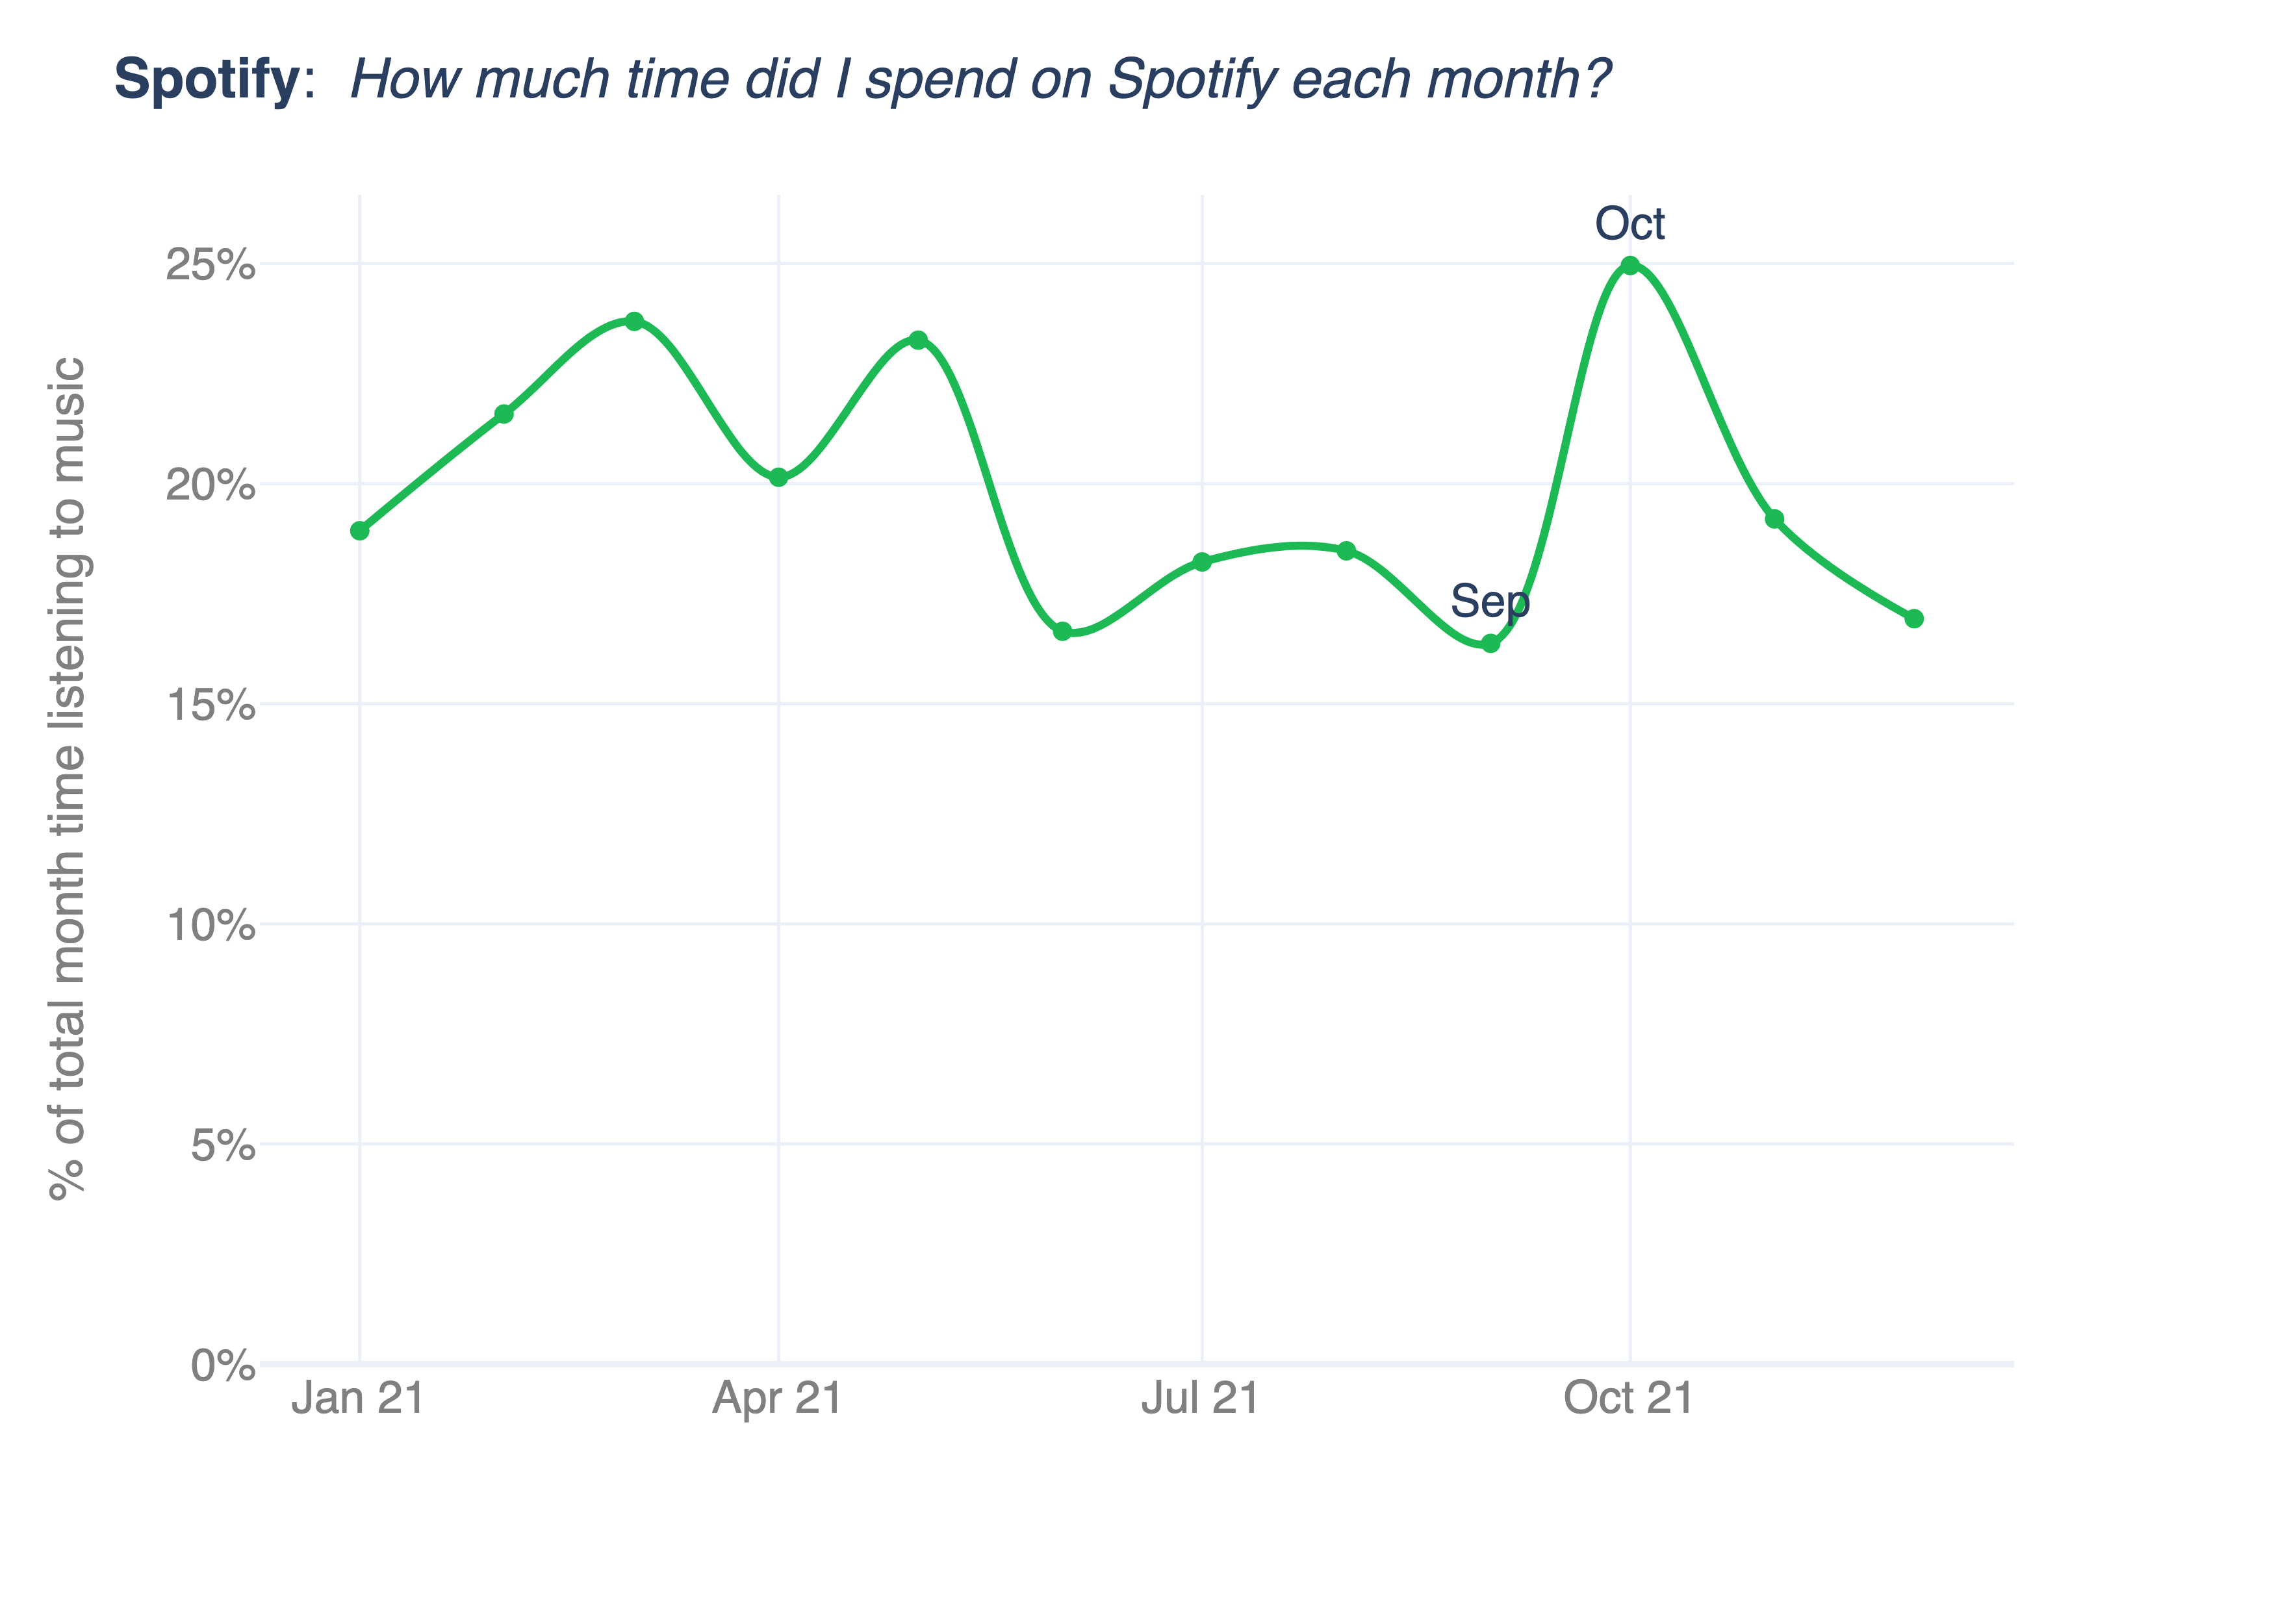

<span style="font-family:Helvetica Light">
    
# 4. When in the week do I listen to music the most?
    
Loading neccessary libraries.
    
Loading the json files from the requested data sent by Spotify.
    
</span>

In [12]:
# Dow x Hours
df_daily_sum = hour_df\
                .groupby(['date', 'dow', 'day'], as_index=False)\
                .agg({'value':'sum'})

df_daily_sum = df_daily_sum\
                .groupby(['dow', 'day'], as_index=False)\
                .agg({'value':'mean'})\
                .sort_values(by='dow')

In [13]:
fig = px.line(df_daily_sum, x='day', y='value', color_discrete_sequence=spotify_colors, line_shape='spline')
fig.update_traces(mode='lines+markers+text', texttemplate='%{y:.1f}h', textposition='top center')
fig.update_yaxes(rangemode='tozero', ticksuffix='h', nticks=2)

fig.update_layout(
    title='<b>Spotify</b>: <i>When in the week do I listen to music the most?</i>',
    yaxis_title='Average hours listened per day',
    yaxis_range=[0,7],
    xaxis_title='Day of the week'
    
)
write('medium', fig, 'hours_per_day')

<span style="font-family:Helvetica Light">
    
# 5. How do I use Spotify around the clock?
    
Loading neccessary libraries.
    
Loading the json files from the requested data sent by Spotify.
    
</span>

In [14]:
df_hour = hour_df\
                .groupby(['hour'], as_index=False)\
                .agg({'value':'mean'})\
                .sort_values(by=['hour'])

df_hour['hour_to_minutes'] = df_hour['value']*60

In [15]:
palette = sns.color_palette("YlGn", 24).as_hex() #RdYlBu

fig = go.Figure(go.Barpolar(
    r=df_hour.hour_to_minutes,
    theta=np.linspace(0, 360, 24, endpoint=False),
    width=15,
    marker_color=palette,
    marker_line_color='white',
    marker_line_width=0.10,
    #opacity=0.9,
    offset=0
))

num_slices=24
angular_tickvals = [(i) * 360 / num_slices for i in range(num_slices)]

labels = [time(i, 0).strftime("%H:%M") for i in df_hour.index]

fig.update_layout(
    title='<b>Spotify</b>: <i> Listening clock</i>',
    template=None,
    #polar_angularaxis_tickvals=angular_tickvals,
    polar = dict(
        bgcolor='#e5ecf6',
        radialaxis = dict(range=[0, 25], 
                          showticklabels=False,
                          #showgrid=False
                          ticks='', 
                          nticks=1,
                          color='grey', 
                          linewidth=0),
        angularaxis = dict(showticklabels=True, 
                           ticks='',
                           tickfont_size = 8,
                           tickfont_color = 'black',
                           rotation = 90,
                           direction = "clockwise",
                           color='white', 
                           tickmode='array',
                           tickvals=angular_tickvals,
                           ticktext=labels,
                           #tickcolor='yellow'
                           )
        
    )
)

write('medium', fig, 'listening_clock')

<span style="font-family:Helvetica Light">
    
# 6. Do my habits change during the weekend?
    
Loading neccessary libraries.
    
Loading the json files from the requested data sent by Spotify.
    
</span>

In [16]:
hour_df['week_period'] = hour_df['dow'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekdays')

df_weekend = hour_df\
                .groupby(['hour', 'week_period'], as_index=False)\
                .agg({'value':'mean'})\
                .sort_values(by=['week_period', 'hour'])

df_weekend['hour_to_minutes'] = df_weekend['value']*60
df_weekend['text'] = ''

df_weekend.loc[(df_weekend['week_period'] == 'Weekdays') & (df_weekend['hour'].isin([8, 10, 18])), 'text'] = df_weekend['hour'].apply(lambda x: "{:.0f}h".format(x))
df_weekend.loc[(df_weekend['week_period'] == 'Weekend') & (df_weekend['hour'].isin([10, 18, 21])), 'text'] = df_weekend['hour'].apply(lambda x: "{:.0f}h".format(x))

In [17]:
fig = px.line(df_weekend, x='hour', y='hour_to_minutes', color='week_period', text='text',
              line_shape='spline', color_discrete_sequence=spotify_colors)

fig.update_traces(mode='lines+markers+text', textposition='top center', line_width=2.5)
fig.update_yaxes(rangemode='tozero', ticksuffix='min', nticks=5)
fig.update_xaxes(title='', ticksuffix=':00', tickangle=45)

fig.update_layout(
    title='<b>Spotify</b>: <i>Do my habits change during the weekend?</i>',
    legend_title='Week period',
    legend_orientation='h',
    yaxis_title='Average time listening to music (min)',
)

write('medium', fig, 'weekday_vs_weekend')


<span style="font-family:Helvetica Light">
    
# 7. Do I skip songs a lot?
    
Loading neccessary libraries.
    
Loading the json files from the requested data sent by Spotify.
    
</span>

In [18]:
df['sec_disc'] = np.floor(df['sPlayed'])
df_skip = df.groupby(['sec_disc'], as_index=False).agg({'trackName':'count'}).sort_values(by='sec_disc')
df_skip['percent'] = df_skip.sort_values(by='sec_disc')['trackName'].cumsum()/df_skip['trackName'].sum()
df_skip = df_skip.loc[df_skip['percent'] < 0.99]

In [19]:
fig = px.histogram(df_skip, x='sec_disc', y='trackName', histfunc='sum', histnorm='percent', nbins=50, 
                   color_discrete_sequence=spotify_colors)
fig.update_yaxes(ticksuffix='%')
fig.update_xaxes(dtick=30)
fig.update_layout(
    title='<b>Spotify</b>: <i>Do I skip songs a lot?</i>',
    yaxis_title='Share of streams',
    xaxis_title='Seconds of song'
)


write('medium', fig, 'skips')


<span style="font-family:Helvetica Light"> 
    
Loading neccessary libraries.
    
Loading the json files from the requested data sent by Spotify.    
    
# 8. What is the proportion of music vs podcasts?
    
</span>

In [20]:
df['streamType'] = np.where(df['podcastName'].isna(), 'music', 'podcast')
df.groupby('streamType').size()

streamType
music      44755
podcast      330
dtype: int64

In [21]:
fig = px.pie(df, values='hPlayed', names='streamType', color_discrete_sequence=spotify_colors)

fig.update_traces(textposition='inside', 
                  textinfo='percent+label',
                  pull=[0.3, 0], 
                  rotation=280, 
                  texttemplate="%{label}: %{percent:.0%}")


fig.update_layout(
    title='<b>Spotify</b>: <i>What is the proportion of music vs podcasts?</i>',
    #legend_title='Week period',
    #legend_orientation='h',
    #yaxis_title='Average time listening to music (min)',
)

write('medium', fig, 'music_vs_podcasts')


<span style="font-family:Helvetica Light">
    
# 9. What were my top podcasts of the year?
    
Loading neccessary libraries.
    
Loading the json files from the requested data sent by Spotify.
    
</span>

In [22]:
df_podcasts = df.loc[(df['streamType']=='podcast') & (df['sPlayed']>60)]

top_podcasts = df_podcasts.groupby(['podcastName','imageUrl'], as_index=False).agg({'hPlayed':'sum', 'trackName':'nunique'})

top_podcasts.sort_values(by='hPlayed', ascending=False, ignore_index=True, inplace=True)
top_podcasts_by_hrs = top_podcasts.head(10).reset_index()


In [23]:
fig = px.bar(top_podcasts_by_hrs, y='podcastName', x='hPlayed', facet_col_spacing=0.1,
                color_discrete_sequence=spotify_colors)

fig.update_yaxes(autorange='reversed', zeroline=False, tickfont_size=14)
fig.update_xaxes(rangemode='tozero', range=[-0.5, 20], tickfont_size=14)


fig.update_layout(
    title='<b>Spotify</b>: <i>What were my top podcasts of the year?</i>',
    xaxis_title='Hours Listened',
    yaxis_title='Top 10 most listened podcasts'
)


multiplier = 1.35

for i, row in top_podcasts_by_hrs.iterrows():
    fig.update_traces(marker_color="rgba(0,0,0,0)")
    image = row['imageUrl']
    fig.add_layout_image(
        dict(
            source=f'{image}',
            xref="x",
            yref="y",
            xanchor="center",
            yanchor="middle",
            x=row["hPlayed"],
            y=row["index"],
            sizex=multiplier, 
            sizey=multiplier, 
#             sizey=np.sqrt(row["uri"] / top["uri"].max()) * multiplier,
#             sizex=np.sqrt(row["uri"] / top["uri"].max()) * multiplier,
            sizing="contain",
            opacity=1,
            layer="above"
        )
    )

write('medium', fig, 'podcasts')


<span style="font-family:Helvetica Light">

# 10. How did my musical moods change?

Spotify Platform provides vast array of <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features" target="_blank">audio features </a> of tracks such as tempo, instrumentalness, energy and more. They consider following features as those representing specific moods:
<blockquote>
    
* <b>danceability</b> - describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* <b>energy</b> - is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* <b>tempo</b> - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
* <b>valence</b> - a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
    
</blockquote>

    
### Moods during the day     
</span>

In [24]:
df_music = df.loc[~df['trackId'].isnull()]

df_feats = df_music\
        .groupby(['hour'], as_index=False)\
        .agg({'hPlayed':'sum', 'danceability':'median', 'energy':'median', 'valence':'median'})\
        .sort_values(by=['hour'])

        #.groupby(['month'], as_index=False)\

df_feats = df_feats.iloc[6:].reset_index(drop=True)

In [25]:
scaler = StandardScaler()

df_features = df_feats.iloc[:, 2:]
cols = df_features.columns.tolist()

df_features = pd.DataFrame(scaler.fit_transform(df_features))
df_features.columns = cols

df_feats.iloc[:, 2:] = df_features

df_feats= pd.melt(df_feats, id_vars=['hour', 'hPlayed'], value_vars=cols)

In [26]:
fig = px.line(df_feats, x='hour', y='value', 
              # puts charts next to each other; facet_row would put them under one another
              facet_col='variable', facet_col_spacing=0.08, #text='text', 
              color_discrete_sequence=spotify_colors, line_shape='spline', 
              category_orders={'variable':['danceability', 'energy', 'valence']}
             )

fig.update_yaxes(showticklabels=True, tickvals=[-2,0, 2],  
                 tickmode='array', title='', range=[-3, 3], tickfont_size=14)
fig.update_yaxes(col=1, ticktext=['Less<br>dancing', 'Year avg', 'More<br>dancing'])
fig.update_yaxes(col=2, ticktext=['Chill', ' ', 'Frenzy'])
fig.update_yaxes(col=3, ticktext=['Downer',' ', 'Upbeat'])

fig.update_traces(mode='lines+markers+text', textposition='middle right', 
                  textfont_size=12, line_width=2.5
                 )


fig.update_layout(
    title='<b>Spotify: </b><i>How was my musical emotional state during the day?</i>',
    margin_t=120,
    showlegend=False
)
fig.for_each_annotation(lambda a: a.update(text="<b>{}</b>".format(a.text.split('=')[1].title())))

write('medium', fig,'moods_day', True, False)


<span style="font-family:Helvetica Light">
    
### Moods over the year   

</span>

In [27]:
df_music = df.loc[~df['trackId'].isnull()]

df_feats = df_music\
        .groupby(['month'], as_index=False)\
        .agg({'hPlayed':'sum', 'danceability':'median', 'energy':'median', 'valence':'median'})\
        .sort_values(by=['month'])


In [28]:
scaler = StandardScaler()

df_features = df_feats.iloc[:, 2:]
cols = df_features.columns.tolist()

df_features = pd.DataFrame(scaler.fit_transform(df_features))
df_features.columns = cols

df_feats.iloc[:, 2:] = df_features

df_feats= pd.melt(df_feats, id_vars=['month', 'hPlayed'], value_vars=cols)

In [29]:
fig = px.line(df_feats, x='month', y='value', 
              # puts charts next to each other; facet_row would put them under one another
              facet_col='variable', facet_col_spacing=0.08, #text='text', 
              color_discrete_sequence=spotify_colors, line_shape='spline', 
              category_orders={'variable':['danceability', 'energy', 'valence']}
             )

fig.update_yaxes(showticklabels=True, tickvals=[-2,0, 2],  
                 tickmode='array', title='', range=[-3, 3], tickfont_size=14)
fig.update_yaxes(col=1, ticktext=['Less<br>dancing', 'Year avg', 'More<br>dancing'])
fig.update_yaxes(col=2, ticktext=['Chill', ' ', 'Frenzy'])
fig.update_yaxes(col=3, ticktext=['Downer',' ', 'Upbeat'])

fig.update_traces(mode='lines+markers+text', textposition='middle right', 
                  textfont_size=12, line_width=2.5
                 )

fig.update_xaxes(title='', tickvals=['2021-01-01', '2021-07-01', '2021-12-01'],
                 tickformat='%b/%y', range=['2020-12-15', '2022-01-15']
                )
fig.update_layout(
    title='<b>Spotify: </b><i>How was my musical emotional state during 2021?</i>',
    margin_t=120,
    showlegend=False
)
fig.for_each_annotation(lambda a: a.update(text="<b>{}</b>".format(a.text.split('=')[1].title())))

write('medium', fig,'moods_year', True, False)



<span style="font-family:Helvetica Light">

# 10. What were my the most popular genres?

Using Spotify Platform one can also access a list of the genres the artist is associated with using <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/get-multiple-artists" target="_blank">artists endpoint</a> in the API call.
    
</span>

In [30]:
df_genres = df[['endTime','artistName','trackName', 'hPlayed', 'artistGenres']].copy()
df_genres.dropna(subset=['artistGenres'], inplace=True)
df_genres.head(3)

,endTime,artistName,trackName,hPlayed,artistGenres
0,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,0.012452,"['polish alternative', 'polish pop']"
1,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,0.008819,"['dance pop', 'pop']"
2,2021-01-01 06:04:00,Justin Bieber,Anyone,0.052994,"['canadian pop', 'pop']"


<span style="font-family:Helvetica Light">
    
The artistGenres are stored as lists. 
    
Expanding them into rows will help with the anaysis.
    
As some of the genres are similar: pop, polish pop, canadian pop etc, in next step I groupped them into _meta genres_. My assumption was to take last word of more specific genre, eg.: _canadian pop_ gets meta genre _pop_ etc.
    
</span>

In [31]:
import ast
df_genres.artistGenres = df_genres.artistGenres.apply(ast.literal_eval)
df_genres = df_genres.explode('artistGenres').reset_index(drop=True)
df_genres.dropna(subset=['artistGenres'], inplace=True)
df_genres.head(6)

,endTime,artistName,trackName,hPlayed,artistGenres
0,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,0.012452,polish alternative
1,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,0.012452,polish pop
2,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,0.008819,dance pop
3,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,0.008819,pop
4,2021-01-01 06:04:00,Justin Bieber,Anyone,0.052994,canadian pop
5,2021-01-01 06:04:00,Justin Bieber,Anyone,0.052994,pop


In [32]:
def last_word(str):
    res = str.split(' ')
    fin = res[len(res)-1]
    return fin

#some manual adjustments
df_genres['artistGenres'] = df_genres.artistGenres.str.replace("hip hop", "hip-hop")
df_genres['artistGenres'] = df_genres.artistGenres.str.replace("electropop", "electro pop")
df_genres['artistGenres'] = df_genres.artistGenres.str.replace("alt z", "alt-z")

df_genres['metaGenre']=df_genres.artistGenres.apply(last_word)

df_genres.drop_duplicates(subset=['endTime','artistName','trackName','hPlayed','metaGenre'], inplace=True, ignore_index=True, keep='first')


In [33]:
genres = pd.DataFrame(df_genres.groupby('metaGenre')['hPlayed'].sum())\
    .sort_values(by='hPlayed', ascending=False)\
    .reset_index()

In [34]:
genres.head(11)

,metaGenre,hPlayed
0,pop,1268.884545
1,r&b,330.301398
2,rap,172.673362
3,soul,140.069245
4,hip-hop,108.341912
5,house,73.584812
6,dance,66.574776
7,rock,59.622033
8,edm,49.490753
9,contemporary,49.214281


In [35]:
fig = px.pie(genres, values='hPlayed', names='metaGenre', color_discrete_sequence=spotify_colors)

fig.update_traces(textposition='inside', 
                  textinfo='percent+label',
                  #pull=[0.3, 0], 
                  #rotation=280, 
                  texttemplate="%{label}: %{percent:.0%}")


fig.update_layout(
    title='<b>Spotify</b>: <i>What were my the most popular genres?</i>',
    #legend_title='Week period',
    #legend_orientation='h',
    #yaxis_title='Average time listening to music (min)',
)

write('medium', fig, 'genres')

